In [1]:
# importing libs
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, GaussianNoise
from keras.models import Model
from keras import regularizers
from keras.layers import BatchNormalization
from keras.optimizers import SGD
import random as rn

In [2]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/vidits-kth/py-itpp.git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
autoconf is already the newest version (2.71-2).
autoconf set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  libtool-doc gcj-jdk
The following NEW packages will be installed:
  libtool
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 164 kB of archives.
After this operation, 1,227 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libtool all 2.4.6-15build2 [164 kB]
Fetched 164 kB in 15s (10.6 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: un

In [ ]:
#CREATE A FILE IN py-itpp/src/comm WITH THE NAME reedsolomon.h AND PUT THIS PART
'''
#include <pybind11/pybind11.h>
#include <pybind11/operators.h>

#include <itpp/comm/reedsolomon.h>

namespace py = pybind11;




void generate_pybind_wrapper_for_itpp_reedsolomon_class( py::module &m, const char * name ) {

  py::class_<itpp::Reed_Solomon>( m, "Reed_Solomon" )
    .def( py::init<short, short,const bool,const short>() )

    .def("encode", static_cast<void (itpp::Reed_Solomon::*)(const itpp::bvec &, itpp::bvec &)>(&itpp::Reed_Solomon::encode))
    .def("encode", static_cast<itpp::bvec (itpp::Reed_Solomon::*)(const itpp::bvec &)>(&itpp::Reed_Solomon::encode))


    .def("decode", static_cast<void (itpp::Reed_Solomon::*)(const itpp::bvec &, itpp::bvec &)>(&itpp::Reed_Solomon::decode))
    .def("decode", static_cast<itpp::bvec (itpp::Reed_Solomon::*)(const itpp::bvec &)>(&itpp::Reed_Solomon::decode))

    .def("get_rate", &itpp::Reed_Solomon::get_rate)

  ;
}
'''

#CREATE A FILE IN py-itpp/src/comm WITH THE NAME reedsolomon.cpp AND PUT THIS PART
'''
#include "reedsolomon.h"

PYBIND11_MODULE(reedsolomon, m)
{
  generate_pybind_wrapper_for_itpp_reedsolomon_class( m, "Reed_Solomon" );
}
'''

#ADD THIS LINE IN py-itpp/src/comm/__init__.py
'''
from .reedsolomon import *
'''

In [3]:
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .
!cd py-itpp; ls ; pip3 install -e .
!cat py-itpp/setup.py
#following 3 lines are added to resolve the issue
import sys
sys.path.append('./py-itpp/lib')
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 4.7 MB/s eta 0:00:00
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [419 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [842 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,082 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [960 kB]
Get:12 http://arch

In [4]:
import pyitpp as itpp
from matplotlib import pyplot as plt

In [54]:
from scipy.constants import Avogadro, speed_of_light, pi, Boltzmann


Gas_list = ['N2', 'O2', 'CO2', 'O3', 'CH4', 'H2', 'N2O', 'H2O']
Gas_mix_ratio = {"N2": 0.78,
                 "O2": 0.21,
                 "CO2": 365 * 10 ** (-6),
                 "O3": 10 * 10 ** (-6),
                 "CH4": 1.7 * 10 ** (-6),
                 "H2": 500 * 10 ** (-9),
                 "N2O": 320 * 10 ** (-9),
                 "H2O": 0.0096}

frequency = 0.35 * 10 ** 12     # 0.3 THz
distances = np.arange(1.5,20.0,0.5)[::-1]
distances = distances**2          # 1m
temperature = 296.0            # in Kelvin
pressure = 1.0                 # atm


def k_abs(frequency, Gases, Gases_ratio, P, T):
    def map_f_to_nu(f):
        # in our case f will be given in THz, and nu is in cm-1
        return f * 33.35641 * 10 ** (-12)

    def get_absorption_cross_section():
        nu = {}
        absorption_cross_section = {}
        for gas in Gas_list:
            try:
                _res = np.genfromtxt(f'absorption_cross_section_{gas}.csv', delimiter=',')
                nu[gas] = _res[:, 0]
                absorption_cross_section[gas] = _res[:, 1] #* 10 ** (-4)
            except IndexError:
                print(f"E: data of gas: {gas} is missing")
                nu[gas] = np.array([0])
                absorption_cross_section[gas] = np.array([0])
        return absorption_cross_section, nu

    def individual_absorption_coefficient(f, gas, nu, absorption_cross_section):
        def get_measured_frequency(f, gas, nu):
            _nu = map_f_to_nu(f)
            _absolute_difference_function = lambda list_value: abs(list_value - _nu)
            _closest_nu = min(nu[gas], key=_absolute_difference_function)
            _index = np.where(nu[gas] == _closest_nu)[0][0]
            return _closest_nu, _index

        _nu, _index = get_measured_frequency(f, gas, nu)
        _absorption_cross_section = absorption_cross_section[gas][_index]
        return (P / STANDARD_PRESSURE) * (
                TEMPERATURE_AT_STANDARD_PRESSURE / T) * _absorption_cross_section * (
                       P / (GAS_CONSTANT * T) * Gas_mix_ratio[gas] * AVOGADRO_CONSTANT)

    # Constants
    STANDARD_PRESSURE = 1013.25  # [hPa]
    TEMPERATURE_AT_STANDARD_PRESSURE = 273.15  # [K]
    GAS_CONSTANT = 8.2051 * 10 ** (-5)
    AVOGADRO_CONSTANT = Avogadro

    absorption_cross_section, nu = get_absorption_cross_section()

    return sum(individual_absorption_coefficient(frequency, gas, nu, absorption_cross_section) for gas in Gas_list)

def SNR(P_tx, F, D, T, Kf):
    alpha = speed_of_light**2 / 16 * pi**2
    P_rx = P_tx * alpha * F**(-2) * D**(-2) * np.exp(-Kf * D)
    P_noise = Boltzmann * T + P_tx * alpha * F**(-2) * D**(-2) * (1 - np.exp(-Kf * D))

    return P_rx / P_noise


Kf_param = k_abs(frequency,Gas_list, Gas_mix_ratio, pressure, temperature)
print(Kf_param)






0.007032232968028951


In [7]:
def rs_64qam(bits,m,t,SNRs):

  BER = []


  block_size = (2 ** m) - (1 + 2 * t)
  n = (2 ** m) - 1
  rate = float(block_size)/float(n)

  #Encoding the generated bits
  rs = itpp.comm.Reed_Solomon(m,t,False,1)
  encoded_bits = rs.encode(bits)

  #Modulating the encoded bits
  modulator_ = itpp.comm.QAM(64)
  tx_signal = modulator_.modulate_bits(encoded_bits)

  for snr in SNRs:
    #Adding Channel noise effect

    noise_variance = 1/(2*rate*snr)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)

    #Demodulating the noisy bits
    demodulated_bits = modulator_.demodulate_bits(rx_signal)

    #Decoding the demodulated bits
    decoded_bits = rs.decode(demodulated_bits)

    #Calculating Block Error Rate
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(bits, decoded_bits)

    BER.append(blerc.get_errorrate())
  return BER


In [8]:

def rs_16qam(bits,m,t,SNRs):

  BER = []

  block_size = (2 ** m) - (1 + 2 * t)
  n = (2 ** m) - 1
  rate = float(block_size)/float(n)

  #Encoding the generated bits
  rs = itpp.comm.Reed_Solomon(m,t,False,1)
  encoded_bits = rs.encode(bits)

  #Modulating the encoded bits
  modulator_ = itpp.comm.QAM(16)
  tx_signal = modulator_.modulate_bits(encoded_bits)

  for snr in SNRs:
    #Adding Channel noise effect

    noise_variance = 1/(2*rate*snr)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)

    #Demodulating the noisy bits
    demodulated_bits = modulator_.demodulate_bits(rx_signal)

    #Decoding the demodulated bits
    decoded_bits = rs.decode(demodulated_bits)

    #Calculating Block Error Rate
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(bits, decoded_bits)

    BER.append(blerc.get_errorrate())
  return BER

In [10]:
def rs_8psk(bits,m,t,SNRs):

  BER = []

  block_size = (2 ** m) - (1 + 2 * t)
  n = (2 ** m) - 1
  rate = float(block_size)/float(n)

  #Encoding the generated bits
  rs = itpp.comm.Reed_Solomon(m,t,False,1)
  encoded_bits = rs.encode(bits)

  #Modulating the encoded bits
  modulator_ = itpp.comm.PSK(8)
  tx_signal = modulator_.modulate_bits(encoded_bits)

  for snr in SNRs:
    #Adding Channel noise effect

    noise_variance = 1/(2*rate*snr)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)

    #Demodulating the noisy bits
    demodulated_bits = modulator_.demodulate_bits(rx_signal)

    #Decoding the demodulated bits
    decoded_bits = rs.decode(demodulated_bits)

    #Calculating Block Error Rate
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(bits, decoded_bits)

    BER.append(blerc.get_errorrate())
  return BER

In [11]:
def rs_qpsk(bits,m,t,SNRs):

  BER = []

  block_size = (2 ** m) - (1 + 2 * t)
  n = (2 ** m) - 1
  rate = float(block_size)/float(n)

  #Encoding the generated bits
  rs = itpp.comm.Reed_Solomon(m,t,False,1)
  encoded_bits = rs.encode(bits)

  #Modulating the encoded bits
  modulator_ = itpp.comm.QPSK()
  tx_signal = modulator_.modulate_bits(encoded_bits)

  for snr in SNRs:
    #Adding Channel noise effect

    noise_variance = 1/(2*rate*snr)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)

    #Demodulating the noisy bits
    demodulated_bits = modulator_.demodulate_bits(rx_signal)

    #Decoding the demodulated bits
    decoded_bits = rs.decode(demodulated_bits)

    #Calculating Block Error Rate
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(bits, decoded_bits)

    BER.append(blerc.get_errorrate())
  return BER

In [12]:
def rs_bpskc(bits,m,t,SNRs):

  BER = []

  block_size = (2 ** m) - (1 + 2 * t)
  n = (2 ** m) - 1
  rate = float(block_size)/float(n)

  #Encoding the generated bits
  rs = itpp.comm.Reed_Solomon(m,t,False,1)
  encoded_bits = rs.encode(bits)

  #Modulating the encoded bits
  modulator_ = itpp.comm.BPSK_c()
  tx_signal = modulator_.modulate_bits(encoded_bits)

  for snr in SNRs:
    #Adding Channel noise effect

    noise_variance = 1/(2*rate*snr)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)

    #Demodulating the noisy bits
    demodulated_bits = modulator_.demodulate_bits(rx_signal)

    #Decoding the demodulated bits
    decoded_bits = rs.decode(demodulated_bits)

    #Calculating Block Error Rate
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(bits, decoded_bits)

    BER.append(blerc.get_errorrate())
  return BER

In [55]:
snrs = []
for distance in distances:
  snrs.append(SNR(100, frequency, distance, temperature, Kf_param))

#Generating Random bits
source_bits = itpp.randb(1000000)

print("------------Calculating BLER for QPSK------------")
ber_rs_qp = rs_qpsk(source_bits, 3, 2, snrs)
print("------------Calculating BLER for 8PSK------------")
ber_rs_8p = rs_8psk(source_bits, 3, 2, snrs)
print("------------Calculating BLER for 16QAM------------")
ber_rs_16q = rs_16qam(source_bits, 3, 2, snrs)
print("------------Calculating BLER for 64QAM------------")
ber_rs_64q = rs_64qam(source_bits, 3, 2, snrs)


------------Calculating BLER for QPSK------------
------------Calculating BLER for 8PSK------------
------------Calculating BLER for 16QAM------------
------------Calculating BLER for 64QAM------------


In [56]:
print("------------Calculating BLER for BPSK------------")
ber_rs_bp = rs_bpskc(source_bits, 3, 2, snrs)


------------Calculating BLER for BPSK------------


In [57]:
def autoenco(k,n,SNRs):
  BER = []
  R = float(k/n)
  Nt = 10000
  M = 2**k
  label = np.random.randint(M,size=Nt)
  data = []
  for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)
  data = np.array(data)



  input_signal = Input(shape=(M,))
  encoded = Dense(M, activation='relu')(input_signal)
  encoded1 = Dense(n, activation='linear')(encoded)
  encoded2 = BatchNormalization()(encoded1)

  EbNo_train = 10 ** (0.7)
  encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

  decoded = Dense(M, activation='relu')(encoded3)
  decoded1 = Dense(M, activation='softmax')(decoded)

  autoencoder = Model(input_signal, decoded1)
  #sgd = SGD(lr=0.001)
  autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')
  print(autoencoder.summary())

  N_val = 1500
  val_label = np.random.randint(M,size=N_val)
  val_data = []
  for i in val_label:
    temp = np.zeros(M)
    temp[i] = 1
    val_data.append(temp)
  val_data = np.array(val_data)

  autoencoder.fit(data, data,epochs=30,batch_size=300,validation_data=(val_data, val_data),callbacks=[ModelCheckpoint(save_best_only=True, filepath="ok")])
  autoencoder.load_weights("ok")

  encoder = Model(input_signal, encoded2)
  encoded_input = Input(shape=(n,))

  deco = autoencoder.layers[-2](encoded_input)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = Model(encoded_input, deco)

  N = 50000
  test_label = np.random.randint(M,size=N)
  test_data = []

  for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)

  test_data = np.array(test_data)

  for snr in SNRs:

    noise_std = np.sqrt(1/(2*R*snr))
    noise_mean = 0
    no_errors = 0
    noise = np.random.normal(0,noise_std,(N,n))
    encoded_signal = encoder.predict(test_data)
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    BER.append(no_errors / N)
  return BER

In [58]:
from keras.callbacks import ModelCheckpoint


In [59]:
ber_autoenco = autoenco(3, 7, snrs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 7)                 63        
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 7)                0         
 se)                                                             
                                                                 
 dense_2 (Dense)             (None, 8)                 64    

In [67]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Convolution2D, Activation, Flatten, MaxPooling2D,Input,Dropout,GlobalAveragePooling2D
from keras import backend as K
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.layers import Layer
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.layers import BatchNormalization
from tensorflow.python.framework import ops

In [68]:
def binarize(x):
    '''Element-wise rounding to the closest integer with full gradient propagation.
    A trick from [Sergey Ioffe](http://stackoverflow.com/a/36480182)
    '''
    clipped = K.clip(x,-1,1)
    rounded = K.sign(clipped)
    return clipped + K.stop_gradient(rounded - clipped)

In [69]:
class Residual_sign(Layer):
    def __init__(self, levels=1,**kwargs):
        self.levels=levels
        super(Residual_sign, self).__init__(**kwargs)
    def build(self, input_shape):
        ars=np.arange(self.levels)+1.0
        ars=ars[::-1]
        means=ars/np.sum(ars)
        self.means=[K.variable(m) for m in means]
        self._trainable_weights=self.means
    def call(self, x, mask=None):
        resid = x
        out_bin=0
        for l in range(self.levels):
            out=binarize(resid)*K.abs(self.means[l])
            out_bin=out_bin+out
            resid=resid-out
        return out_bin

    def get_output_shape_for(self,input_shape):
        return input_shape
    def compute_output_shape(self,input_shape):
		    return input_shape
    def set_means(self,X):
        means=np.zeros((self.levels))
        means[0]=1
        resid=np.clip(X,-1,1)
        approx=0
        for l in range(self.levels):
            m=np.mean(np.absolute(resid))
            out=np.sign(resid)*m
            approx=approx+out
            resid=resid-out
            means[l]=m
            err=np.mean((approx-np.clip(X,-1,1))**2)

        means=means/np.sum(means)
        sess=K.get_session()
        sess.run(self.means.assign(means))

In [70]:
class binary_conv(Layer):
	def __init__(self,nfilters,ch_in,k,padding,strides=(1,1),**kwargs):
		self.nfilters=nfilters
		self.ch_in=ch_in
		self.k=k
		self.padding=padding
		self.strides=strides
		super(binary_conv,self).__init__(**kwargs)
	def build(self, input_shape):
		stdv=1/np.sqrt(self.k*self.k*self.ch_in)
		w = np.random.normal(loc=0.0, scale=stdv,size=[self.k,self.k,self.ch_in,self.nfilters]).astype(np.float32)
		if keras.backend._backend=="mxnet":
			w=w.transpose(3,2,0,1)
		self.w=K.variable(w)
		self.gamma=K.variable(1.0)
		self.trainable_weights=[self.w,self.gamma]


	def call(self, x,mask=None):
		constraint_gamma=K.abs(self.gamma)#K.clip(self.gamma,0.01,10)
		self.clamped_w=constraint_gamma*binarize(self.w)
		if keras.__version__[0]=='2':
			self.out=K.conv2d(x, kernel=self.clamped_w, padding=self.padding,strides=self.strides )
		if keras.__version__[0]=='1':
			self.out=K.conv2d(x,self.clamped_w,border_mode=self.padding,strides=self.strides)
		self.output_dim=self.out.get_shape()
		return self.out
	def  get_output_shape_for(self,input_shape):
		return (input_shape[0], self.output_dim[1],self.output_dim[2],self.output_dim[3])
	def compute_output_shape(self,input_shape):
		return (input_shape[0], self.output_dim[1],self.output_dim[2],self.output_dim[3])


In [72]:
class binary_dense(Layer):
	def __init__(self,n_in,n_out,**kwargs):
		self.n_in=n_in
		self.n_out=n_out
		super(binary_dense,self).__init__(**kwargs)
	def build(self, input_shape):
		stdv=1/np.sqrt(self.n_in)
		w = np.random.normal(loc=0.0, scale=stdv,size=[self.n_in,self.n_out]).astype(np.float32)
		self.w=K.variable(w)
		self.gamma=K.variable(1.0)
		self._trainable_weights=[self.w,self.gamma]

	def call(self, x,mask=None):
		constraint_gamma=K.abs(self.gamma)#K.clip(self.gamma,0.01,10)
		self.clamped_w=constraint_gamma*binarize(self.w)
		self.out=K.dot(x,self.clamped_w)
		return self.out
	def  get_output_shape_for(self,input_shape):
		return (input_shape[0], self.n_out)
	def compute_output_shape(self,input_shape):
		return (input_shape[0], self.n_out)

In [83]:
def rebnetauto(re,k,n,SNRs):
  bers = []

  #Creating one-hot vector training dataset corresponding to binary message

  Nt = 10000                                      #No. of messages                                           #block size
  M = 2**k                                        #one-hot vector size
  label = np.random.randint(M,size=Nt)
  data = []
  for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)
  data = np.array(data)                           #training dataset

  #Creating Validation dataset

  N_val = 1500
  val_label = np.random.randint(M,size=N_val)
  val_data = []
  for i in val_label:
    temp = np.zeros(M)
    temp[i] = 1
    val_data.append(temp)
  val_data = np.array(val_data)

  #Creating testing dataset

  N = 100000
  test_label = np.random.randint(M,size=N)
  test_data = []

  for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)

  test_data = np.array(test_data)

  #Create the corresponding binary model

  BER = []

  #the model layers

  input = Input(shape=(M,))
  enco1 = binary_dense(n_in=M,n_out=M)(input)
  encor = Residual_sign(levels=re)(enco1)
  enco2 = binary_dense(n_in=M,n_out=n)(encor)

  norm = BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-4)(enco2)

  EbNo_train = 10 ** (0.7)
  enco3 = keras.layers.GaussianNoise(np.sqrt(1/(2*(k/n)*EbNo_train)))(norm)     #train for SNR = 7 db

  deco1 = binary_dense(n_in=n,n_out=M)(enco3)
  decor = Residual_sign(levels=re)(deco1)
  deco2 = binary_dense(n_in=M,n_out=M)(decor)
  last = Activation('softmax')(deco2)

  opt = keras.optimizers.Adam(learning_rate=0.01,decay=1e-6)
  model = Model(input, last)
  model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

  model.fit(data, data,epochs=25,batch_size=300,validation_data=(val_data, val_data), callbacks=[ModelCheckpoint(save_best_only=True, filepath=str(re))])
  model.load_weights(str(re))

  #Encoder model
  encoder = Model(input, norm)

  #Receiver model
  encoded_input = Input(shape=(n,))

  decor = model.layers[-4](encoded_input)
  deco2 = model.layers[-3](decor)
  deco1 = model.layers[-2](deco2)
  deco = model.layers[-1](deco1)
  decoder = Model(encoded_input, deco)

  #Testing on SNR range


  for snr in SNRs:

    noise_std = np.sqrt(1/(2*(k/n)*snr))
    noise_mean = 0
    no_errors = 0
    noise = np.random.normal(0,noise_std,(N,n))
    encoded_signal = encoder.predict(test_data)
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    BER.append(no_errors / N)
  return BER

In [84]:
ber_reb1 = rebnetauto(1,3,7,snrs)
ber_reb2 = rebnetauto(2,3,7,snrs)
ber_reb3 = rebnetauto(3,3,7,snrs)

Epoch 1/25
34/34 [==============================] - 3s 57ms/step - loss: 2.9284 - accuracy: 0.2890 - val_loss: 1.2138 - val_accuracy: 0.4873
Epoch 2/25
34/34 [==============================] - 2s 50ms/step - loss: 1.0740 - accuracy: 0.5615 - val_loss: 0.8862 - val_accuracy: 0.6220
Epoch 3/25
34/34 [==============================] - 2s 69ms/step - loss: 0.8208 - accuracy: 0.6788 - val_loss: 0.3664 - val_accuracy: 0.7493
Epoch 4/25
26/34 [=====================>........] - ETA: 0s - loss: 0.4947 - accuracy: 0.8432

34/34 [==============================] - 2s 74ms/step - loss: 0.4664 - accuracy: 0.8487 - val_loss: 0.1672 - val_accuracy: 1.0000
Epoch 5/25
34/34 [==============================] - 0s 5ms/step - loss: 0.3592 - accuracy: 0.8682 - val_loss: 0.3470 - val_accuracy: 0.8627
Epoch 6/25
34/34 [==============================] - 0s 6ms/step - loss: 0.3347 - accuracy: 0.8716 - val_loss: 0.4329 - val_accuracy: 0.7387
Epoch 7/25
34/34 [==============================] - 2s 52ms/step - loss: 0.3733 - accuracy: 0.8476 - val_loss: 0.1306 - val_accuracy: 1.0000
Epoch 8/25
34/34 [==============================] - 0s 6ms/step - loss: 0.2753 - accuracy: 0.9065 - val_loss: 0.2409 - val_accuracy: 0.8733
Epoch 9/25
34/34 [==============================] - 0s 6ms/step - loss: 0.3106 - accuracy: 0.8889 - val_loss: 0.4093 - val_accuracy: 0.8733
Epoch 10/25
34/34 [==============================] - 2s 52ms/step - loss: 0.2433 - accuracy: 0.9241 - val_loss: 0.1070 - val_accuracy: 1.0000
Epoch 11/25
34/34 [========

34/34 [==============================] - 4s 80ms/step - loss: 1.5854 - accuracy: 0.5130 - val_loss: 0.5722 - val_accuracy: 1.0000
Epoch 2/25
34/34 [==============================] - 2s 55ms/step - loss: 0.7118 - accuracy: 0.7690 - val_loss: 0.2400 - val_accuracy: 1.0000
Epoch 3/25
34/34 [==============================] - 0s 6ms/step - loss: 0.5015 - accuracy: 0.8058 - val_loss: 0.4768 - val_accuracy: 0.7533
Epoch 4/25
34/34 [==============================] - 2s 55ms/step - loss: 0.3451 - accuracy: 0.8808 - val_loss: 0.2179 - val_accuracy: 0.8733
Epoch 5/25
34/34 [==============================] - 2s 65ms/step - loss: 0.1135 - accuracy: 0.9571 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 6/25
34/34 [==============================] - 2s 58ms/step - loss: 0.0631 - accuracy: 0.9803 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 7/25
34/34 [==============================] - 3s 84ms/step - loss: 0.1089 - accuracy: 0.9597 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 8/25
34/34 [=======

34/34 [==============================] - 3s 83ms/step - loss: 0.3226 - accuracy: 0.8776 - val_loss: 0.1444 - val_accuracy: 1.0000
Epoch 4/25
34/34 [==============================] - 2s 63ms/step - loss: 0.2426 - accuracy: 0.9199 - val_loss: 0.0629 - val_accuracy: 1.0000
Epoch 5/25
34/34 [==============================] - 2s 62ms/step - loss: 0.1888 - accuracy: 0.9298 - val_loss: 0.0323 - val_accuracy: 1.0000
Epoch 6/25
34/34 [==============================] - 2s 63ms/step - loss: 0.1750 - accuracy: 0.9405 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 7/25
34/34 [==============================] - 3s 87ms/step - loss: 0.0712 - accuracy: 0.9780 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 8/25
34/34 [==============================] - 0s 11ms/step - loss: 0.0797 - accuracy: 0.9732 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 9/25
34/34 [==============================] - 3s 76ms/step - loss: 0.0438 - accuracy: 0.9870 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 10/25
34/34 [=====

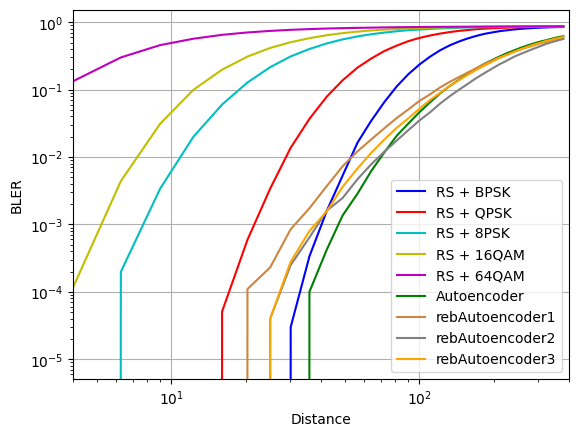

In [85]:
plt.figure()
plt.grid(True)
plt.xlim(4,400)
plt.xlabel('Distance')
plt.ylabel('BLER')
plt.semilogy(distances, ber_rs_bp, c = 'blue', label = 'RS + BPSK')
plt.semilogy(distances, ber_rs_qp, c = 'r', label = 'RS + QPSK')
plt.semilogy(distances, ber_rs_8p, c = 'c', label = 'RS + 8PSK')
plt.semilogy(distances, ber_rs_16q, c = 'y', label = 'RS + 16QAM')
plt.semilogy(distances, ber_rs_64q, c = 'm', label = 'RS + 64QAM')
plt.semilogy(distances, ber_autoenco, c = 'g', label = 'Autoencoder')
plt.semilogy(distances, ber_reb1, c = 'peru', label = 'rebAutoencoder1')
plt.semilogy(distances, ber_reb2, c = 'gray', label = 'rebAutoencoder2')
plt.semilogy(distances, ber_reb3, c = 'orange', label = 'rebAutoencoder3')
plt.legend(loc='best')
plt.xscale('log')